# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

## Aggregating diverse distance functions

We want to combine different distance metrics operating on subsets of the data to one distance value. As a toy model, assume we want to combine a Laplace and a Normal distance.

In [1]:
import pyabc
import numpy as np
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * np.random.normal(), 
            's1': p['p1'] + 0.1 * np.random.normal()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return (x['s1'] - x_0['s1'])**2

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2020-05-17 19:07:50.881259, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.0385570782028162
INFO:ABC:t: 0, eps: 1.0385570782028162.
INFO:ABC:Acceptance rate: 100 / 161 = 6.2112e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.6266478571969578.
INFO:ABC:Acceptance rate: 100 / 227 = 4.4053e-01, ESS=9.8797e+01.
INFO:ABC:t: 2, eps: 0.3797778758541551.
INFO:ABC:Acceptance rate: 100 / 263 = 3.8023e-01, ESS=9.6432e+01.
INFO:ABC:t: 3, eps: 0.23271514846350852.
INFO:ABC:Acceptance rate: 100 / 249 = 4.0161e-01, ESS=8.2414e+01.
INFO:ABC:t: 4, eps: 0.14867766193042023.
INFO:ABC:Acceptance rate: 100 / 277 = 3.6101e-01, ESS=7.4941e+01.
INFO:ABC:t: 5, eps: 0.09375644596444883.
INFO:ABC:Acceptance rate: 100 / 402 = 2.4876e-01, ESS=8.3770e+01.
INFO:History:Done <ABCSMC(id=1, start_time=2020-05-17 19:07:50.881259, end_time=2020-05-17 19:07:57.400829)>


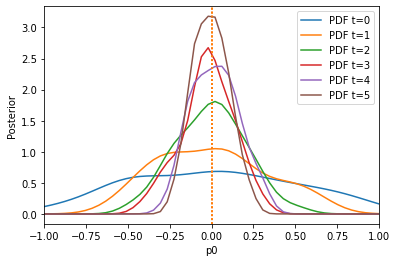

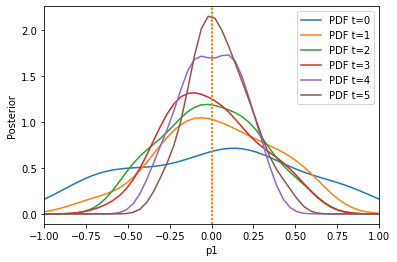

In [2]:
distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting

def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot_history(history1)

## Weighted aggregation

A problem with the previous aggregation of distance function is that usually they vary on different scales. In order to account for all in a similar manner, one thing one can do is to weight them.

Let us look at a simple example of two summary statistics which vary on very different scales:

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=2, start_time=2020-05-17 19:07:58.540981, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 4323.119783938766
INFO:ABC:t: 0, eps: 4323.119783938766.
INFO:ABC:Acceptance rate: 100 / 204 = 4.9020e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 983.687851784918.
INFO:ABC:Acceptance rate: 100 / 380 = 2.6316e-01, ESS=8.6737e+01.
INFO:ABC:t: 2, eps: 212.01991735522245.
INFO:ABC:Acceptance rate: 100 / 970 = 1.0309e-01, ESS=8.3643e+01.
INFO:ABC:t: 3, eps: 49.848612246498334.
INFO:ABC:Acceptance rate: 100 / 1660 = 6.0241e-02, ESS=9.1908e+01.
INFO:ABC:t: 4, eps: 12.207788840598266.
INFO:ABC:Acceptance rate: 100 / 3263 = 3.0647e-02, ESS=8.9227e+01.
INFO:ABC:t: 5, eps: 3.2591185551715833.
INFO:ABC:Acceptance rate: 100 / 7422 = 1.3473e-02, ESS=9.0671e+01.
INFO:History:Done <ABCSMC(id=2, start_time=2020-05-17 19:07:58.540981, end_time=2020-05-17 19:08:20.718662)>


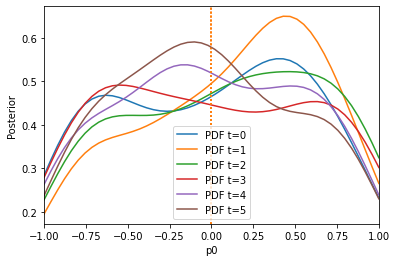

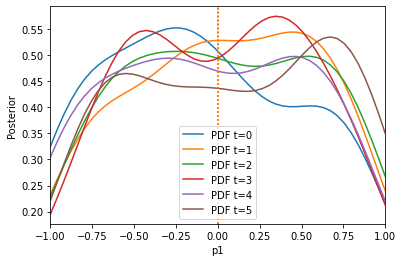

In [3]:
import pyabc
import numpy as np
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * np.random.normal(), 
            's1': p['p1'] + 100 * np.random.normal()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return (x['s1'] - x_0['s1'])**2

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting

def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot_history(history1)

The algorithm has problems extracting information from the first summary statistic on the first parameter, because the second summary statistic is on a much larger scale. Let us use the `pyabc.distance.AdaptiveAggregatedDistance` instead, which tries to find good weights itself (and even adapts these weights over time):

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=3, start_time=2020-05-17 19:08:22.020127, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.584370579542136
INFO:ABC:t: 0, eps: 0.584370579542136.
INFO:ABC:Acceptance rate: 100 / 194 = 5.1546e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.6947726110213078.
INFO:ABC:Acceptance rate: 100 / 237 = 4.2194e-01, ESS=9.4883e+01.
INFO:ABC:t: 2, eps: 0.7810550392598525.
INFO:ABC:Acceptance rate: 100 / 297 = 3.3670e-01, ESS=8.7866e+01.
INFO:ABC:t: 3, eps: 0.6964029572131732.
INFO:ABC:Acceptance rate: 100 / 340 = 2.9412e-01, ESS=9.3900e+01.
INFO:ABC:t: 4, eps: 0.6563335926638891.
INFO:ABC:Acceptance rate: 100 / 561 = 1.7825e-01, ESS=8.7756e+01.
INFO:ABC:t: 5, eps: 0.7396888829703054.
INFO:ABC:Acceptance rate: 100 / 881 = 1.1351e-01, ESS=8.9301e+01.
INFO:History:Done <ABCSMC(id=3, start_time=2020-05-17 19:08:22.020127, end_time=2020-05-17 19:08:28.121491)>


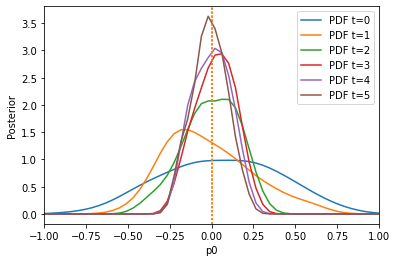

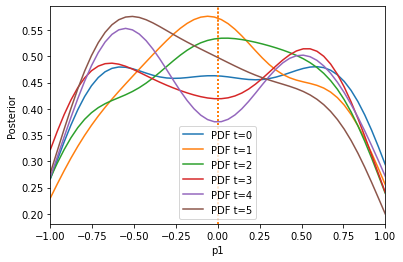

In [4]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AdaptiveAggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=6)

plot_history(history2)

The result is much better. We can also only initially calculate weights by setting `adaptive=False`:

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=4, start_time=2020-05-17 19:08:29.746638, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.5422601259707908
INFO:ABC:t: 0, eps: 0.5422601259707908.
INFO:ABC:Acceptance rate: 100 / 206 = 4.8544e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.3171556467305309.
INFO:ABC:Acceptance rate: 100 / 215 = 4.6512e-01, ESS=9.2208e+01.
INFO:ABC:t: 2, eps: 0.19220858620929399.
INFO:ABC:Acceptance rate: 100 / 250 = 4.0000e-01, ESS=9.5807e+01.
INFO:ABC:t: 3, eps: 0.11699645089129365.
INFO:ABC:Acceptance rate: 100 / 443 = 2.2573e-01, ESS=8.5142e+01.
INFO:ABC:t: 4, eps: 0.0745616388302114.
INFO:ABC:Acceptance rate: 100 / 624 = 1.6026e-01, ESS=8.8944e+01.
INFO:ABC:t: 5, eps: 0.044523155316940115.
INFO:ABC:Acceptance rate: 100 / 1267 = 7.8927e-02, ESS=7.9595e+01.
INFO:History:Done <ABCSMC(id=4, start_time=2020-05-17 19:08:29.746638, end_time=2020-05-17 19:08:36.384282)>


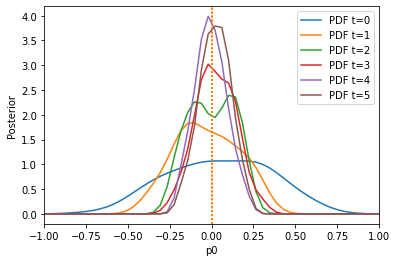

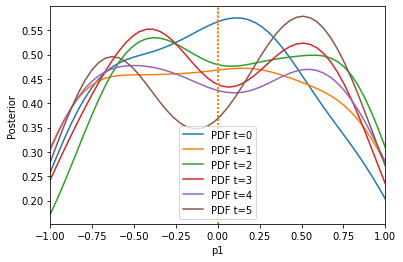

In [5]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AdaptiveAggregatedDistance(
    [distance0, distance1], adaptive=False)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=6)

plot_history(history3)

Here, pre-calibration performs comparable to adaptation, because the weights do not change so much over time. Note that one can also specify other scale functions, by passing ``AdaptiveAggregatedDistance(distances, scale_function)``, e.g. ``pyabc.distance.mean[/median/span]``.

The following plots demonstrate that we not only have a much better posterior approximation after the same number of iterations in the second and third run compared to the first, but we achieve that actually with a much lower number of samples.

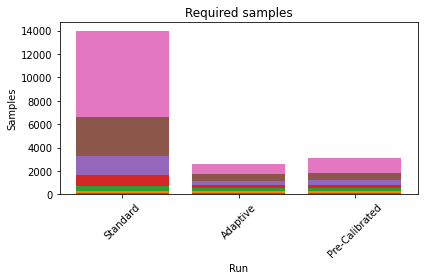

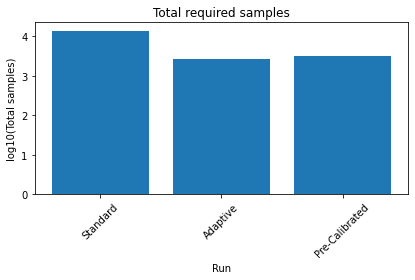

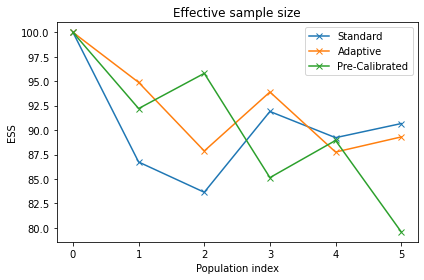

In [6]:
histories = [history1, history2, history3]
labels = ["Standard", "Adaptive", "Pre-Calibrated"]

pyabc.visualization.plot_sample_numbers(histories, labels, rotation=45)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10', rotation=45)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)